### Kuramoto-Sivashinsky Equation and spectral solution
We consider a periodic domain $[0,L)$ for the solution of the Kuramoto-Sivashinsky equation:
$$
\begin{align*}
u_t= -u_{xx} - u_{xxxx} - \frac12(u^2)_x.
\end{align*}
$$

Our periodic grid has $N$ points $\{x_n\}_{n=1}^N$, where $x_n = n\Delta x$ and $\Delta x = L/N$. With $N$ degrees of freedom we can write the solution $u(x,t)$ as a truncated Fourier expansion with $N$ modes:
$$
\begin{align*}
u(x,t) = \sum_{k=-N/2}^{N/2-1}\hat{u}_k(t)\exp\left(\frac{2\pi jkx}{L}\right).
\end{align*}
$$

We can thus write a system of ODEs for the coefficients $\hat{\mathbf{u}}=(\hat{u}_{-N/2},\hat{u}_{-N/2+1},\ldots,\hat{u}_{N/2-1})^\top$:
\begin{align*}
\hat{\mathbf{u}}_t = \mathbf{A}\hat{\mathbf{u}} + \mathbf{F}(\hat{\mathbf{u}})
\end{align*}
where the linear operator $\mathbf{A}$ is diagonal with entries $(2\pi k/L)^2 - (2\pi k/L)^4$ which come from the second and fourth spatial derivative terms, and the nonlinear operator $\mathbf{F}$ represents the flux term.

We solve the above ODEs with a Crank-Nicolson + Adams-Bashforth semi-implicit scheme. The implementation of the nonlinearity is naive and could likely be improved somehow.

# Function

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse

'''
Generate random parameters with zero-mean and periodic boundary condition in [0, L]
(-D + τ^2)^{-d}
 
'''
def GRF1D(nx, L, theta, d=2.0, tau=3.0):
    n_KL = len(theta)
    assert(n_KL%2 == 0)
    theta_c, theta_s = theta[0:n_KL//2], theta[n_KL//2:]
    xx = np.linspace(0, L, nx)
    u = np.zeros(nx)
    for l in range(n_KL//2):
        lam = 1.0/( (2*np.pi*l/L)**d + tau**(2*d) )
        u += theta_c[l] * np.sqrt(lam)*np.sqrt(2/L) * np.cos(2*np.pi * xx/L)
        u += theta_s[l] * np.sqrt(lam)*np.sqrt(2/L) * np.sin(2*np.pi * xx/L)
    
    
    return u


def Kuramoto_Sivashinsky(L = 100, nx = 1024, T = 1000.0, dt = 0.05, u0=None, plot_or_not = True):
    
#     L  = 100
#     nx = 1024
#     dt = 0.05
#     T = 1000
    
    dx = L/nx
    nt = np.round(T/dt).astype(int)

    # meshes
    t = np.arange(stop=T+dt,step=dt)    # time mesh
    x = np.arange(stop=L,step=dx)       # space mesh
    k = np.arange(-nx/2,nx/2,1)         # wave numbers

    # pre-allocate space for solution
    u  = np.zeros((nx,nt+1))
    uh = np.zeros((nx,nt+1),dtype=complex)

    # initial condition
    if u0 is None:
        u0 = np.cos((2*np.pi*x)/L) + 0.1*np.cos((4*np.pi*x)/L)
        
    u[:,0]  = u0
    uh[:,0] = 1/nx*np.fft.fftshift(np.fft.fft(u[:,0]))


    A = (2*np.pi*k/L)**2 - (2*np.pi*k/L)**4
    F = -0.5*(1j*2*np.pi*k/L)

    for i in range(nt):
        # u2h = 1/nx*np.fft.fftshift(np.fft.fft(u[:,i]**2))
        u2h = np.convolve(uh[:,i],uh[:,i])[nx//2 :(nx+nx//2)]
        if i == 0:
            print(u2h.shape)

        if i == 0:
            uh[:,i+1] =1/(1-0.5*dt*A)*((1+0.5*dt*A)*uh[:,i] + 1.0*dt*F*u2h)
        else:
            uh[:,i+1] =1/(1-0.5*dt*A)*((1+0.5*dt*A)*uh[:,i] + 1.5*dt*F*u2h-0.5*dt*F*u2hlast)
        u[:,i+1]  = np.real(nx*np.fft.ifft(np.fft.ifftshift(uh[:,i+1])))
        # clean 
        uh[:,i+1] = 1/nx*np.fft.fftshift(np.fft.fft(u[:,i+1]))
        u2hlast = u2h.copy()


    if plot_or_not:
        fig,ax = plt.subplots(figsize=(4,3))
        xx,tt=np.meshgrid(x,t)
        cs = ax.contourf(xx,tt,u.T,cmap="BrBG")
        fig.colorbar(cs)
        # plt.savefig('xt.pdf')
        plt.show()
    
    return u, uh

(1024,)


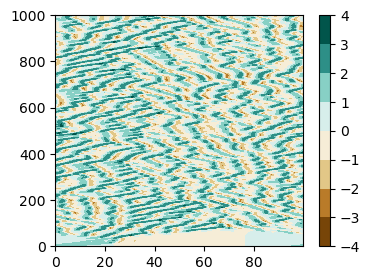

(array([[ 1.1       ,  1.10027437,  1.10052372, ..., -1.4323012 ,
         -1.44156501, -1.45058516],
        [ 1.09997365,  1.10027771,  1.10055681, ..., -1.37626687,
         -1.38685573, -1.39723734],
        [ 1.09989458,  1.10022831,  1.10053716, ..., -1.31322709,
         -1.32492708, -1.33645588],
        ...,
        [ 1.09976282,  1.09994803,  1.10010808, ..., -1.54547743,
         -1.54947566, -1.55312558],
        [ 1.09989458,  1.10010952,  1.10029934, ..., -1.5181928 ,
         -1.52415779, -1.52980782],
        [ 1.09997365,  1.10021831,  1.10043789, ..., -1.48004164,
         -1.48776375, -1.49520604]]),
 array([[-3.08997619e-18+0.00000000e+00j,  2.27682456e-18+0.00000000e+00j,
         -2.87313576e-18+0.00000000e+00j, ...,
          6.01732206e-16+0.00000000e+00j, -5.96744876e-16+0.00000000e+00j,
          5.96311195e-16+0.00000000e+00j],
        [ 0.00000000e+00-9.74765516e-18j,  5.55111512e-17+9.91367361e-18j,
          0.00000000e+00+1.30104261e-18j, ...,
          6

In [6]:
Kuramoto_Sivashinsky(L = 100, nx = 1024, T = 1000.0, dt = 0.05, u0=None, plot_or_not = True)

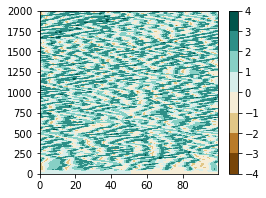

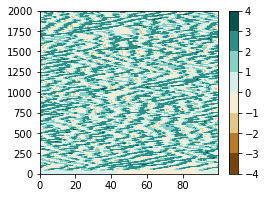

In [51]:
np.random.seed(42)
n_data = 2
nx = 1024
T = 2000.0
dt = 0.05
nt = np.round(T/dt).astype(int)

u0 = np.zeros((nx, n_data))
u,uh = np.zeros((nx, nt+1, n_data)), np.zeros((nx, nt+1, n_data),dtype=complex)

theta = np.random.normal(loc=0.0, scale=1.0, size=(1024,n_data))

for i_data in range(n_data):
    u0[:, i_data] = GRF1D(nx, L, theta[:,i_data], d=2.0, tau=3.0)
    u[:, :, i_data],uh[:, :, i_data] = Kuramoto_Sivashinsky(L = 100, nx = nx, T = T, dt = dt, u0=u0[:, i_data], plot_or_not = True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


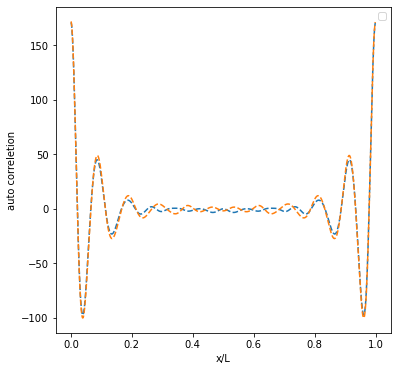

In [52]:
# Auto correlation
auto_correletion = np.zeros((nx, n_data))
for i_data in range(n_data):
    Cx = np.zeros((nx, nt))
    for i in range(nt):
        Cx[:, i] = np.real(nx*np.fft.ifft(np.fft.ifftshift(uh[:, i, i_data] * np.conj(uh[:, i, i_data])) )) 

    n_burn = nt//10
    auto_correletion[:, i_data] = L/(nt - n_burn) * (np.sum(Cx[:, n_burn:], axis=1)[:])

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x/L, auto_correletion, "--")
ax.set_xlabel("x/L")
ax.set_ylabel("auto correletion")
ax.legend()

/var/folders/sq/9dntw6953x7fn5kvr7xqnr680000gn/T/ipykernel_9773/2366425517.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  Ex[:, i] = (np.fft.ifftshift(uh[:, i, i_data] * np.conj(uh[:, i, i_data])))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


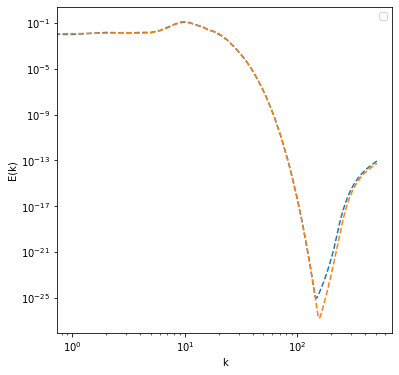

In [53]:
# Energy spectral
energy_spectral = np.zeros((nx, n_data))
for i_data in range(n_data):
    Ex = np.zeros((nx, nt))
    for i in range(nt):
        Ex[:, i] = (np.fft.ifftshift(uh[:, i, i_data] * np.conj(uh[:, i, i_data])))

    n_burn = nt//10
    energy_spectral[:, i_data] = 1/(nt - n_burn) *(np.sum(Ex[:, n_burn:], axis=1))


fig, ax = plt.subplots(figsize=(6,6))
ax.loglog(energy_spectral[1:nx//2, :], "--")
ax.set_xlabel("k")
ax.set_ylabel("E(k)")
ax.legend()


In [54]:
# print(nx/3)
# uh_trunc = uh[:,i].copy()
# uh_trunc[:170] = 0
# uh_trunc[-170:] = 0
# temp = np.convolve(uh_trunc,uh_trunc)[nx//2:(nx+nx//2)]


M = nx*3//2
xM = np.arange(stop=L,step=L/M)       # space mesh
uh_pad = np.zeros((M,),dtype=complex)
uh_pad[M//6:-M//6] = uh[:,i]
u_pad = M*np.fft.ifft(np.fft.ifftshift(uh_pad))


u2h_pad = 1/M*np.fft.fftshift(np.fft.fft(u_pad**2))[M//6:-M//6]
# u2h_conv = np.convolve(uh_pad,uh_pad)[nx//2:(nx+nx//2)]
u2h_conv = np.convolve(uh_pad,uh_pad,"same")[M//6:-M//6]
print(np.linalg.norm(u2h-u2h_conv))
print(np.linalg.norm(u2h-u2h_pad))
print(np.linalg.norm(u2h_conv-u2h_pad))


fig,ax = plt.subplots(2,2,figsize=(8,5))
ax[0,0].plot(x,u[:,i],label="ifft(uh)")
ax[0,0].plot(xM,u_pad,linestyle="dotted",label="ifft(uh_pad)")
ax[0,0].legend()
ax[0,0].set_ylabel("u")
ax[0,1].plot(k,uh[:,i])
ax[0,1].set_ylabel("$\hat{u}$")
ax[1,0].plot(u[:,i]**2)
ax[1,0].set_ylabel("$u^2$")
ax[1,1].plot(k,u2h,label="fft(u**2)")
ax[1,1].plot(k,u2h_conv,linestyle="dotted",label="conv(uh,uh)")
ax[1,1].plot(k,u2h_pad,linestyle="dashed")
ax[1,1].set_ylabel("$\hat{u}^2$")
ax[1,1].legend()
plt.tight_layout()
# plt.savefig('temp.pdf')
# plt.close("all")


ValueError: could not broadcast input array from shape (1024,2) into shape (1024,)

In [40]:

# print(nx/3)
# uh_trunc = uh[:,i].copy()
# uh_trunc[:170] = 0
# uh_trunc[-170:] = 0
# temp = np.convolve(uh_trunc,uh_trunc)[nx//2:(nx+nx//2)]



xM = np.arange(stop=L,step=L/nx)       # space mesh
uh_pad = np.zeros((nx,),dtype=complex)
uh_pad[nx//6:-nx//6] = uh[nx//6:-nx//6,i]
u_pad = nx*np.fft.ifft(np.fft.ifftshift(uh_pad))


u2h_pad = 1/nx*np.fft.fftshift(np.fft.fft(u_pad**2))[nx//6:-nx//6]
# u2h_conv = np.convolve(uh_pad,uh_pad)[nx//2:(nx+nx//2)]
u2h_conv = np.convolve(uh_pad,uh_pad,"same")[nx//6:-nx//6]
print(np.linalg.norm(u2h-u2h_conv))
print(np.linalg.norm(u2h-u2h_pad))
print(np.linalg.norm(u2h_conv-u2h_pad))


fig,ax = plt.subplots(2,2,figsize=(8,5))
ax[0,0].plot(x,u[:,i],label="ifft(uh)")
ax[0,0].plot(xM,u_pad,linestyle="dotted",label="ifft(uh_pad)")
ax[0,0].legend()
ax[0,0].set_ylabel("u")
ax[0,1].plot(k,uh[:,i])
ax[0,1].set_ylabel("$\hat{u}$")
ax[1,0].plot(u[:,i]**2)
ax[1,0].set_ylabel("$u^2$")
ax[1,1].plot(k,u2h,label="fft(u**2)")
ax[1,1].plot(k,u2h_conv,linestyle="dotted",label="conv(uh,uh)")
ax[1,1].plot(k,u2h_pad,linestyle="dashed")
ax[1,1].set_ylabel("$\hat{u}^2$")
ax[1,1].legend()
plt.tight_layout()
# plt.savefig('temp.pdf')
# plt.close("all")



ValueError: operands could not be broadcast together with shapes (1024,) (683,) 

In [22]:
# uh


M = nx*3//2
xM = np.arange(stop=L,step=L/M)       # space mesh
uh_pad = np.zeros((M,),dtype=complex)
uh_pad[M//6:-M//6] = uh[:,i]
u_pad = np.real(M*np.fft.ifft(np.fft.ifftshift(uh_pad)))


u2h_pad = 1/M*np.fft.fftshift(np.fft.fft(u_pad**2))[M//6:-M//6]
u2h_conv = np.convolve(uh[:,i],uh[:,i])[nx//2:(nx+nx//2)]
u2h_conv = np.convolve(uh_pad,uh_pad,"same")[M//6:-M//6]
print(np.linalg.norm(u2h-u2h_conv))
print(np.linalg.norm(u2h-u2h_pad))
print(np.linalg.norm(u2h_conv-u2h_pad))

3.8490188989145144
1.3093647430330627e-15
3.849018898914514


In [ ]:
nu = 1
L  = 1
nx = 8  ## SMALL MESH FOR TESTING QUAD NONLINEARITY
dx = L/nx

dt = 0.05
T = 200
nt = np.round(T/dt).astype(int)

# meshes
t = np.arange(stop=T+dt,step=dt)    # time mesh
x = np.arange(stop=L,step=dx)       # space mesh
k = np.arange(-nx/2,nx/2,1)         # wave number
k2 = np.arange(-nx,nx-1)

# initial condition
u_test  = np.cos((2*np.pi*x)/L) + 0.1*np.cos((4*np.pi*x)/L)
uh_test = 1/nx*np.fft.fftshift(np.fft.fft(u_test))
u2h_naive = 1/nx*np.fft.fftshift(np.fft.fft(u_test**2))

# plot initial state, squared initial state, and FFTs of the result
fig,ax = plt.subplots(2,2,figsize=(8,5))
ax[0,0].plot(u_test)
ax[0,0].set_ylabel("u")
ax[0,1].plot(k,uh_test)
ax[0,1].set_ylabel("$\hat{u}$")
ax[1,0].plot(u_test**2)
ax[1,0].set_ylabel("$u^2$")
ax[1,1].plot(k,u2h_naive)
ax[1,1].set_ylabel("$\hat{u}^2$")

# attempt to calculate FFT of u2 from FFT of u without going back to statespace
temp = k[:,None] + k[None,:]
boo = np.convolve(uh_test,uh_test,mode="full")

ax[1,1].plot(k,boo[nx//2:(nx+nx//2)],linestyle="dashed")
ax[1,1].set_xticks(np.arange(-8,7))

plt.tight_layout()
plt.savefig('temp.pdf')
plt.close("all")

[ 4.33334237e-34+0.00000000e+00j  0.00000000e+00-7.22223729e-35j
  2.08166817e-18+0.00000000e+00j  2.08166817e-17-1.73472348e-19j
  2.50000000e-03-1.73472348e-18j  5.00000000e-02+5.72458747e-18j
  2.50000000e-01+5.55111512e-17j  5.00000000e-02-5.89805982e-18j
  5.05000000e-01+0.00000000e+00j  5.00000000e-02+5.89805982e-18j
  2.50000000e-01-5.55111512e-17j  5.00000000e-02-5.72458747e-18j
  2.50000000e-03+1.73472348e-18j  0.00000000e+00+1.73472348e-19j
 -3.00926554e-36+0.00000000e+00j]
4


/Users/elizqian/miniconda3/envs/koi/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/elizqian/miniconda3/envs/koi/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/elizqian/miniconda3/envs/koi/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


: 

: 

: 